In [170]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:75% !important; }</style>"))

import csv
from datetime import datetime
from datetime import timedelta
#from struct import pack
import os
import gc
from numpy import abs, max 
import scipy
#from scipy import io
import numpy as np
from matplotlib import pyplot as plt
#from scipy.signal import butter, lfilter
from scipy import signal
#from scipy.signal import blackman
#from scipy.signal import periodogram
#import gc
#import os
import sys
import pandas as pd
#from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.spatial import distance

gc.enable()

video_start = '20190501'#'20190327'#'20181220' #YYYYMMDD
video_end = '20190501'#'20190327'#'20181220' #YYYYMMDD
data_path = '/data/'
sensor_list = ["acc_w","wifi"]#["gyro","acc2","acc_w","wifi","magnetic"]

temp_video_start = video_start[0:4] + "/" + video_start[4:6] + "/" +video_start[6:8]
temp_video_end = video_end[0:4] + "/" + video_end[4:6] + "/" +video_end[6:8]
print temp_video_start
print temp_video_end

video_startdatte = datetime.strptime(temp_video_start,'%Y/%m/%d')
video_enddate = datetime.strptime(temp_video_end,'%Y/%m/%d')

2019/05/01
2019/05/01


In [270]:
session_list = []
with open('capture_time.csv') as csvfile: #read session data from capture_time.csv
    readCSV = csv.reader(csvfile, delimiter='-')
    line_no = 0
    print "The data sessions taken during the start and end dates"
    for row in readCSV:
        if row[0] != '' and row[1] != '': #Check if both start and end times of each row exists
            starttime = datetime.strptime(row[0],'%Y/%m/%d %H:%M:%S.%f')
            endtime = datetime.strptime(row[1],'%Y/%m/%d %H:%M:%S.%f')
            #print starttime.date()
            if starttime.date() == video_startdatte.date() and endtime.date() == video_enddate.date(): #Check if sessions available which matches the startdate and enddate
                line_no = line_no + 1
                print "(", line_no, ")", "\t", starttime, "-", endtime, "\t", (endtime-starttime).seconds
                session_list.append(row[0] + "-" + row[1])

#print "Please input the session number. Confirm the start and end times using the video."
#session = raw_input("Session ") 
#print "You have chosen the session ", session

The data sessions taken during the start and end dates
( 1 ) 	2019-05-01 16:41:05.611000 - 2019-05-01 16:41:13.163000 	7
( 2 ) 	2019-05-01 16:42:40.785000 - 2019-05-01 16:43:10.407000 	29
( 3 ) 	2019-05-01 16:43:45.472000 - 2019-05-01 16:44:57.964000 	72
( 4 ) 	2019-05-01 16:54:00.370000 - 2019-05-01 16:54:34.154000 	33
( 5 ) 	2019-05-01 17:09:03.935000 - 2019-05-01 17:13:19.206000 	255
( 6 ) 	2019-05-01 17:34:35.146000 - 2019-05-01 17:38:39.256000 	244
( 7 ) 	2019-05-01 17:54:56.137000 - 2019-05-01 17:58:14.905000 	198
( 8 ) 	2019-05-01 17:59:27.842000 - 2019-05-01 18:03:30.776000 	242
( 9 ) 	2019-05-01 18:32:31.120000 - 2019-05-01 18:36:21.541000 	230
( 10 ) 	2019-05-01 18:45:58.958000 - 2019-05-01 18:49:56.742000 	237


In [271]:
sessions = raw_input("Session ")

Session 5,6,8,9,10


In [272]:
sessions = map(int, sessions.split(","))

sessions.sort()

sessions

session_starttime = datetime.strptime(session_list[int(sessions[0])-1][0:23],'%Y/%m/%d %H:%M:%S.%f')

session_endtime = datetime.strptime(session_list[int(sessions[-1])-1][24:47],'%Y/%m/%d %H:%M:%S.%f')

session_list[int(sessions[-1])-1]

print "Start and end times for your selected session are as follows."
print "Start time = ",session_starttime
print "End time = ",session_endtime

Start and end times for your selected session are as follows.
Start time =  2019-05-01 17:09:03.935000
End time =  2019-05-01 18:49:56.742000


In [273]:
start_end_list = []

for session in sessions:
    start_end_list.append([datetime.strptime(session_list[int(session)-1][0:23],'%Y/%m/%d %H:%M:%S.%f'),datetime.strptime(session_list[int(session)-1][24:47],'%Y/%m/%d %H:%M:%S.%f')])

In [274]:
start_end_list

[[datetime.datetime(2019, 5, 1, 17, 9, 3, 935000),
  datetime.datetime(2019, 5, 1, 17, 13, 19, 206000)],
 [datetime.datetime(2019, 5, 1, 17, 34, 35, 146000),
  datetime.datetime(2019, 5, 1, 17, 38, 39, 256000)],
 [datetime.datetime(2019, 5, 1, 17, 59, 27, 842000),
  datetime.datetime(2019, 5, 1, 18, 3, 30, 776000)],
 [datetime.datetime(2019, 5, 1, 18, 32, 31, 120000),
  datetime.datetime(2019, 5, 1, 18, 36, 21, 541000)],
 [datetime.datetime(2019, 5, 1, 18, 45, 58, 958000),
  datetime.datetime(2019, 5, 1, 18, 49, 56, 742000)]]

# Read WiFi data

In [302]:
df_acc2 = pd.DataFrame()
df_acc_w = pd.DataFrame()
df_gyro = pd.DataFrame()
df_magnetic = pd.DataFrame()
results = []

for sensor in sensor_list:
    df = pd.DataFrame()
    for data_filename in os.listdir("data/" + sensor + "/" + video_start): #read data files from data folder
        data_filename = os.path.splitext(data_filename)[0]
        #print datetime.strptime(session_starttime.strftime('%Y/%m/%d %H:%M:%S.%f')[:19],'%Y/%m/%d %H:%M:%S')


        data_filename_datetime = datetime.strptime(data_filename[0:15],'%Y%m%d_%H%M%S')
        #print data_filename_datetime
        if data_filename_datetime >= datetime.strptime(session_starttime.strftime('%Y/%m/%d %H:%M:%S.%f')[:19],'%Y/%m/%d %H:%M:%S') and data_filename_datetime <= datetime.strptime(session_endtime.strftime('%Y/%m/%d %H:%M:%S.%f')[:19],'%Y/%m/%d %H:%M:%S'): #check if the file is in the selected session
            #samplerate, data = wavfile.read(stereo_path + wav_filename +'.wav')
            print "Reading file", data_filename
            if sensor!="wifi":
                df_temp = pd.read_csv("data/" + sensor + "/" + video_start + "/" + data_filename + ".csv")
                #df.index = df['time']
                df_temp.set_index('time', inplace = True)
                #display(df_temp.head())
                df = df.append(df_temp, ignore_index=False)
                
            if sensor=="wifi":
                with open("data/" + sensor + "/" + video_start + "/" + data_filename + ".csv") as csvfile:
                    spamreader = csv.reader(csvfile, delimiter='\t', quotechar='|')
                    for row in spamreader:
                        results.append(row)


    if sensor=="acc2":
        df_acc2=df
    if sensor=="acc_w":
        df_acc_w=df
    if sensor=="gyro":
        df_gyro=df
    if sensor=="magnetic":
        df_magnetic=df
    if sensor=="wifi":
        df_wifi=df
            
#df_acc2 = df_acc2.sort_values(by='time')
#df_acc_w = df_acc_w.sort_values(by='time')
#df_gyro = df_gyro.sort_values(by='time')
#df_magnetic = df_magnetic.sort_values(by='time')

df_acc2.sort_index(inplace=True)
df_acc_w.sort_index(inplace=True)
df_gyro.sort_index(inplace=True)
df_magnetic.sort_index(inplace=True)
#df_wifi = df_wifi.sort_values(by='time')
print "All the data files have been read, appended an sorted according to the time stamps"

Reading file 20190501_183500_acc_w
Reading file 20190501_170930_acc_w
Reading file 20190501_175700_acc_w
Reading file 20190501_173630_acc_w
Reading file 20190501_180130_acc_w
Reading file 20190501_171200_acc_w
Reading file 20190501_184730_acc_w
Reading file 20190501_183330_acc_w
Reading file 20190501_171130_acc_w
Reading file 20190501_184630_acc_w
Reading file 20190501_184930_acc_w
Reading file 20190501_183600_acc_w
Reading file 20190501_183400_acc_w
Reading file 20190501_175430_acc_w
Reading file 20190501_175600_acc_w
Reading file 20190501_175530_acc_w
Reading file 20190501_171000_acc_w
Reading file 20190501_180330_acc_w
Reading file 20190501_183530_acc_w
Reading file 20190501_184900_acc_w
Reading file 20190501_171030_acc_w
Reading file 20190501_183300_acc_w
Reading file 20190501_180100_acc_w
Reading file 20190501_175900_acc_w
Reading file 20190501_173830_acc_w
Reading file 20190501_173600_acc_w
Reading file 20190501_180200_acc_w
Reading file 20190501_173800_acc_w
Reading file 2019050

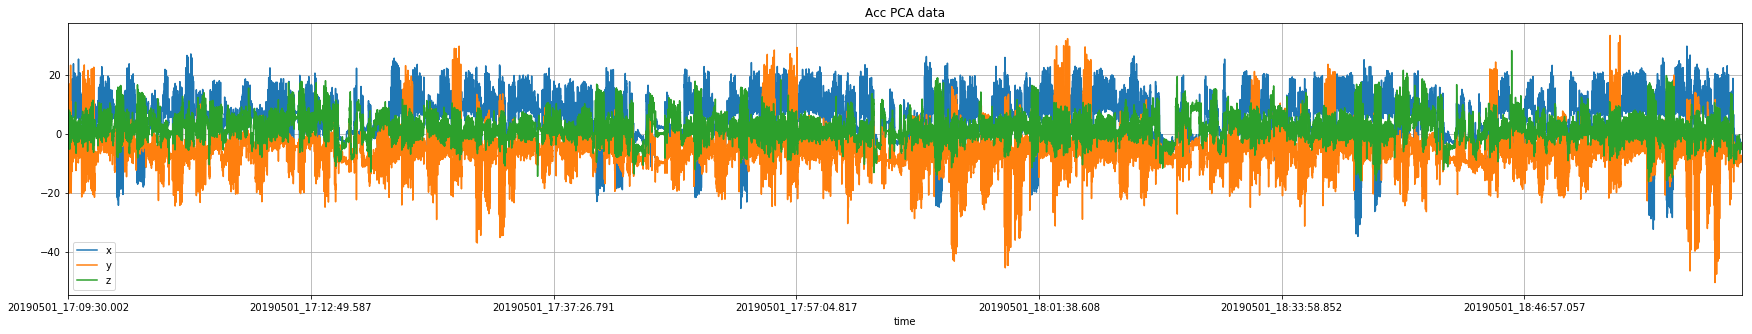

In [294]:
df_acc_w.plot(figsize = (30,5),title="Acc PCA data",grid=1)

In [295]:
df_acc_w.index = pd.to_datetime(df_acc_w.index,format = '%Y%m%d_%H:%M:%S.%f')

# Acceleration feature extraction

In [297]:
def feature_extraction(acc_data):
    acc_data["mean"] = acc_data[["x","y","z"]].mean(axis=1)
    acc_data["std"] = acc_data[["x","y","z"]].std(axis=1)
    df_acc_w["energy"] = (df_acc_w[["x","y","z"]]**2).sum(axis=1)
    
    roll = np.arctan2(acc_data["y"], acc_data["z"]) * 180/np.pi
    pitch = np.arctan2(acc_data["x"], np.sign(acc_data["z"])*np.sqrt(np.power(acc_data["y"],2) + np.power(acc_data["z"],2)))*180/np.pi
    
    acc_data["roll"] = roll
    acc_data["pitch"] = pitch
    
    return acc_data

# Removing unwanted sessions, extracting features and saving

In [301]:
ses_num = 0
df_labels = pd.DataFrame()
labels = pd.DataFrame()
for ses in start_end_list:
    df2 = df_acc_w.loc[ses[0]:ses[1]]
    print ses, len(df2)
    #df2.to_csv("env/" + str(sessions[ses_num]) + "/" + "acc_pca")
    #df2.plot(figsize = (30,5),title="Acc PCA data",grid=1)
    #plt.savefig("env/" + str(sessions[ses_num]) + "/" + "acc_fig")
    #plt.show()
    
    df_labels = pd.read_csv("env/" + str(sessions[ses_num]) + "/" + "labels")
    df_labels.drop(["Unnamed: 0"], axis=1, inplace=True)
    
    if len(df_labels) > len(df2):
        df_labels = df_labels.append(df_labels.iloc[[-1]*(len(df_labels)-len(df2))], ignore_index=True)
        
    elif len(df_labels) < len(df2):
        df_labels = df_labels.append(df_labels.iloc[[-1]*(len(df2)-len(df_labels))], ignore_index=True)
    
    df2 = feature_extraction(df2)
    
    df_labels.index = df2.index
    df2["labels"] = df_labels
    display(df2.head())
    
    df2.to_csv("./env/" + str(sessions[ses_num]) + "/random/" + "feature.csv",header=False)
    print str(sessions[ses_num])
    
    ses_num = ses_num + 1

[datetime.datetime(2019, 5, 1, 17, 9, 3, 935000), datetime.datetime(2019, 5, 1, 17, 13, 19, 206000)] 22920


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,x,y,z,energy,mean,std,roll,pitch,labels
time,,,,,,,,,
2019-05-01 17:09:30.002,-6.151932,13.094650,1.423096,211.341327,2.788605,9.695679,83.797572,-25.035159,bed
2019-05-01 17:09:30.012,-6.264893,11.719070,1.199951,178.025364,2.218043,9.035104,84.153686,-28.004448,bed
2019-05-01 17:09:30.022,-5.984146,10.910080,1.254120,156.412666,2.060018,8.475897,83.442599,-28.586350,bed
2019-05-01 17:09:30.032,-5.659958,10.463760,1.623474,144.161066,2.142425,8.074376,81.180758,-28.125186,bed
2019-05-01 17:09:30.042,-5.387619,10.331375,2.081268,140.095426,2.341675,7.862732,78.610138,-27.076633,bed


5
[datetime.datetime(2019, 5, 1, 17, 34, 35, 146000), datetime.datetime(2019, 5, 1, 17, 38, 39, 256000)] 24300


,x,y,z,energy,mean,std,roll,pitch,labels
time,,,,,,,,,
2019-05-01 17:34:36.345,-0.259872,-9.759171,-2.358551,100.871715,-4.125865,4.990162,-103.586461,-178.517323,din
2019-05-01 17:34:36.355,-0.157364,-10.081146,-2.694763,108.916017,-4.311091,5.155555,-104.965677,-179.136031,din
2019-05-01 17:34:36.365,-0.287811,-10.351852,-2.534393,113.666825,-4.391352,5.282750,-103.756847,-178.453085,din
2019-05-01 17:34:36.375,-0.576202,-10.361069,-2.083481,112.024652,-4.340251,5.268364,-101.369829,-176.879274,din
2019-05-01 17:34:36.385,-0.630463,-9.935226,-1.797363,102.336714,-4.121017,5.068943,-100.254366,-176.426878,din


6
[datetime.datetime(2019, 5, 1, 17, 59, 27, 842000), datetime.datetime(2019, 5, 1, 18, 3, 30, 776000)] 24281


,x,y,z,energy,mean,std,roll,pitch,labels
time,,,,,,,,,
2019-05-01 17:59:28.479,-0.822174,-1.855682,9.928589,102.696407,2.416911,6.525796,-10.586604,-4.653571,din
2019-05-01 17:59:28.489,-0.796112,-2.114868,9.836960,101.872244,2.308660,6.552958,-12.133445,-4.523976,din
2019-05-01 17:59:28.499,-0.822861,-2.451614,9.761368,101.971818,2.162298,6.631185,-14.098499,-4.674021,din
2019-05-01 17:59:28.509,-0.850510,-2.534607,9.774460,102.687668,2.129781,6.673821,-14.537134,-4.814530,din
2019-05-01 17:59:28.519,-0.921082,-2.463318,9.851746,103.973226,2.155782,6.709360,-14.038331,-5.182656,din


8
[datetime.datetime(2019, 5, 1, 18, 32, 31, 120000), datetime.datetime(2019, 5, 1, 18, 36, 21, 541000)] 23032


,x,y,z,energy,mean,std,roll,pitch,labels
time,,,,,,,,,
2019-05-01 18:32:31.634,-2.000961,-1.761032,8.809280,84.708494,1.682429,6.173200,-11.304780,-12.556829,kit
2019-05-01 18:32:31.644,-1.962296,-1.545578,9.001404,87.264689,1.831177,6.213094,-9.742914,-12.125919,kit
2019-05-01 18:32:31.654,-1.847687,-1.426193,9.184097,89.795611,1.970072,6.251082,-8.826926,-11.243837,kit
2019-05-01 18:32:31.664,-1.778305,-1.335876,9.318161,91.775059,2.067993,6.282725,-8.158486,-10.697759,kit
2019-05-01 18:32:31.674,-1.732269,-1.264420,9.361847,92.243693,2.121719,6.274497,-7.691875,-10.390895,kit


9
[datetime.datetime(2019, 5, 1, 18, 45, 58, 958000), datetime.datetime(2019, 5, 1, 18, 49, 56, 742000)] 23680


,x,y,z,energy,mean,std,roll,pitch,labels
time,,,,,,,,,
2019-05-01 18:46:00.096,-3.097473,-10.767303,-1.083923,126.704043,-4.982900,5.109607,-95.748488,-164.027431,bed
2019-05-01 18:46:00.106,-3.054794,-10.637909,-0.741684,123.046971,-4.811462,5.176701,-93.988256,-164.014806,bed
2019-05-01 18:46:00.116,-3.009644,-10.026596,-0.239853,109.648111,-4.425364,5.044629,-91.370349,-163.296541,bed
2019-05-01 18:46:00.126,-3.090469,-9.176529,0.185333,93.794034,-4.027222,4.750710,-88.842986,-18.608951,bed
2019-05-01 18:46:00.136,-3.253876,-8.475861,0.507477,82.685459,-3.740753,4.511416,-86.573610,-20.967476,bed


10
